In [1]:
# 這個Jupyter Notebook的環境
import platform
import tensorflow
import keras
print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(keras.__version__))

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from IPython.display import Image

Platform: Linux-4.13.0-38-generic-x86_64-with-debian-stretch-sid
Tensorflow version: 1.7.0
Keras version: 2.1.5


In [2]:
# 数据集使用之前的dog_vs_cat
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [5]:
#方法1： 特征提取+新的分类层
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

In [6]:
#提取特征步骤
def extract_features(directory, sample_cnt): 
    '''
    sample_cnt:要处理的数目
    '''
    features = np.zeros(shape=(sample_cnt, 4,4,512))#vgg最后一层的输出尺寸
    labels = np.zeros(shape=(sample_cnt))
    
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) #原始层提取特征
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i+=1
        if i*batch_size>=sample_cnt:
            break
    print('extract_features complete')
    return features, labels

In [7]:
train_dir = 'data/train'
valid_dir = 'data/valid'
test_dir = 'data/test'

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)
valid_features, valid_labels = extract_features(valid_dir, 2000)
tests_features, test_labels = extract_features(test_dir, 2000)

Found 4322 images belonging to 2 classes.
extract_features complete
Found 3500 images belonging to 2 classes.
extract_features complete
Found 3890 images belonging to 2 classes.
extract_features complete


In [17]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
valid_features = np.reshape(valid_features, (2000, 4 * 4 * 512))
tests_features = np.reshape(tests_features, (2000, 4 * 4 * 512))

In [18]:
# 连接分类层步骤
from keras import models
from keras.layers import *
from keras import optimizers

model = models.Sequential()
model.add(Dense(256,activation='relu',input_dim=4*4*512))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc']
             )
history = model.fit(train_features,train_labels,
                    epochs=10,
                    batch_size=20,
                    validation_data=(valid_features,valid_labels)
                   )

Train on 2000 samples, validate on 2000 samples
Epoch 1/10
2000/2000 [==============================] - 1s 746us/step - loss: 0.4278 - acc: 0.7935 - val_loss: 0.3098 - val_acc: 0.8690
Epoch 2/10
2000/2000 [==============================] - 0s 216us/step - loss: 0.2781 - acc: 0.8800 - val_loss: 0.2790 - val_acc: 0.8830
Epoch 3/10
2000/2000 [==============================] - 0s 215us/step - loss: 0.2237 - acc: 0.9075 - val_loss: 0.2646 - val_acc: 0.8875
Epoch 4/10
2000/2000 [==============================] - 0s 217us/step - loss: 0.1930 - acc: 0.9275 - val_loss: 0.2851 - val_acc: 0.8705
Epoch 5/10
2000/2000 [==============================] - 0s 216us/step - loss: 0.1678 - acc: 0.9350 - val_loss: 0.2487 - val_acc: 0.8935
Epoch 6/10
2000/2000 [==============================] - 0s 218us/step - loss: 0.1307 - acc: 0.9565 - val_loss: 0.2522 - val_acc: 0.8880
Epoch 7/10
2000/2000 [==============================] - 1s 290us/step - loss: 0.1184 - acc: 0.9665 - val_loss: 0.2485 - val_acc: 0.8925


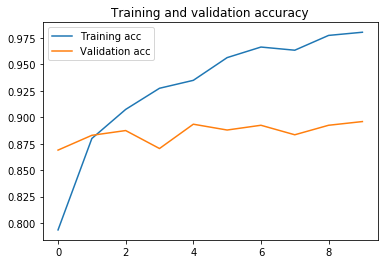

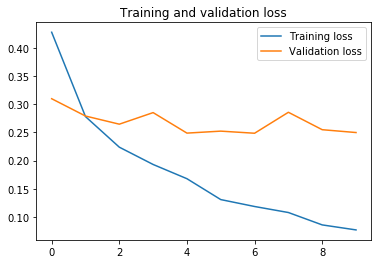

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()